[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Archkras/T1_test/blob/main/notebook/T1_langgraph_rag.ipynb)

# Adaptive RAG

## Setup

First, let's install our required packages and set our API keys

In [1]:
%%capture --no-stderr
! pip install -U langchain_community tiktoken langchain-openai langchain-cohere langchainhub chromadb langchain langgraph  tavily-python

In [2]:
%load_ext autoreload
%autoreload 2

from google.colab import userdata
import os
from pprint import pprint, pformat

OPENAI_API_KEY = "" # add you OPENAI_API_KEY here
TAVILY_API_KEY = "" # add you TAVILY_API_KEY here

os.environ["OPENAI_API_KEY"]= OPENAI_API_KEY if OPENAI_API_KEY else userdata.get('OPENAI_API_KEY1')
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY if TAVILY_API_KEY else userdata.get('TAVILY_KEY')

#os.environ["LANGSMITH_TRACING"]="true"
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGSMITH_ENDPOINT"]=userdata.get('LANGSMITH_ENDPOINT')
# os.environ["LANGSMITH_API_KEY"]=userdata.get('LANGSMITH_API_KEY')
# os.environ["LANGSMITH_PROJECT"]="T1_case"

In [3]:
# import getpass
# import os


# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("OPENAI_API_KEY")
# _set_env("COHERE_API_KEY")
# _set_env("TAVILY_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>.
    </p>
</div>    

In [4]:
#pip install docling

# Load dataset Lenta

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yutkin/corpus-of-russian-news-articles-from-lenta")

print("Path to dataset files:", path)

100%|██████████| 584M/584M [00:19<00:00, 30.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yutkin/corpus-of-russian-news-articles-from-lenta/versions/2


In [6]:
!ls {path}

lenta-ru-news.csv


In [7]:
# !mv {path}/lenta-ru-news.csv /content/lenta-ru-news.csv

In [8]:
# !ls /kaggle/input/corpus-of-russian-news-articles-from-lenta

# Create dataset for RAG database and questions for test

## load csv file

In [9]:
import csv

csv_file = f'{path}/lenta-ru-news.csv'
# take part of big dataset
take_rows = list(range(100,200)) # do not take 0 row (columns name)
row_list_to_load  = [0] + take_rows  #[0, 100, 101, 102, ...]

def get_rows_by_numbers(filename, row_numbers, encoding='utf-8-sig'):
    """Возвращает строки по указанным номерам (начиная с 0)"""
    row_numbers = set(row_numbers)  # Для быстрого поиска
    max_row = max(row_numbers)
    result = []

    with open(filename, 'r', encoding=encoding) as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            if i > max_row:
                break
            if i in row_numbers:
                result.append(row)

    return result


# get columns and rows
columns, *rows = get_rows_by_numbers(csv_file, row_list_to_load)



In [10]:
# columns name and max article length (3754 no need chunking)
print(columns)
max_l=0
for row in rows: #[:2]
    max_l = max(max_l, len(row[2]))
print(max_l)

['url', 'title', 'text', 'topic', 'tags', 'date']
3754


# Новости для которых сгенерируем вопросы

In [11]:
# articles for relevant questions
data_for_q = [rows[x][2] for x in list(range(0,99,9))]
for x in data_for_q:
  print(f'{x[:40]} ... ', f'len: {len(x)}')


В Южно-Сахалинске отмечена вспышка забол ...  len: 1812
По сообщению агентства РИА "Новости", 25 ...  len: 1863
С космодрома "Байконур" в понедельник ос ...  len: 2694
Управляющий   деламипрезидента РФ  Павел ...  len: 3414
Министерство по налогам и сборам (МНС) в ...  len: 1229
Международные нефтяные компании объявили ...  len: 678
За последние два дня в Волгограде зареги ...  len: 1265
Израильское правительство начало освобож ...  len: 1047
Согласно сведениям, поступившим из минис ...  len: 1240
На приморском участке российско-китайско ...  len: 1268
Китайская кинематография стала абсолютно ...  len: 793


In [12]:
# data_for_q

## Вопросы к текстам релевантные

In [13]:
# create by chatGPT for data_for_q questions
Q_relevant = [
"Какие меры были предприняты в Южно-Сахалинске для борьбы со вспышкой холеры среди жителей поселков Христофоровка и Октябрьский?",
"Какую сумму, по данным МВД России и американских спецслужб, получил Шамиль Басаев и сколько из этой суммы он уже истратил во время боевой кампании в Дагестане?",
"Какие спутники были выведены на орбиту с помощью ракеты-носителя 'Протон-К' с космодрома Байконур после двухмесячного перерыва?",
"За что Павел Бородин планирует подать в суд на газету 'Corriere della Sera' и на некоторые российские СМИ?",
"Какое основное нарушение налогового законодательства было выявлено Министерством по налогам и сборам при массовых проверках автозаправочных станций?",
"Сколько, по предварительным данным, составляют запасы газа в открытом месторождении в районе Каспийского моря, относящемся к территории Азербайджана?",
"Кто является возбудителем менингита в Волгограде, и каким образом этот вирус передается человеку?",
"Почему Израиль начал освобождение палестинских заключённых и сколько человек вышло на свободу в первой группе?",
"Какие населённые пункты Чеченской республики были подвергнуты ракетно-бомбовым ударам в ночь и утро, согласно сведениям МВД Чечни?",
"Какую разработанную учеными систему задержали на приморском участке российско-китайской границы и в чем заключалась её двойная направленность?",
"Кто получил главный приз 56-го Венецианского международного кинофестиваля и за какой фильм?"
]

## Вопросы к текстам не релевантные

In [14]:
# create questions by chatGPT for school program
Q_not_relevant = [
    "Кто написал роман «Война и мир»?",
    "Назовите столицу Франции.",
    "Чему равна сумма углов треугольника?",
    "Кто открыл закон всемирного тяготения?",
    "Что такое фотосинтез?",
    "В каком году началась Вторая мировая война?",
    "Какова формула воды?",
    "Перечислите падежи русского языка.",
    "Что показывает географическая широта точки на Земле?",
    "Какой орган отвечает за перекачивание крови в организме человека?"
]

# Retrivers

In [15]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document

### from langchain_cohere import CohereEmbeddings

# Set embeddings
embd = OpenAIEmbeddings()

# # Docs to index
# urls = [
#     "https://lilianweng.github.io/posts/2023-06-23-agent/",
#     "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
#     "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
# ]

# # Load
# docs = [WebBaseLoader(url).load() for url in urls]
# docs_list = [item for sublist in docs for item in sublist]

# # Split
# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=500, chunk_overlap=0
# )
# doc_splits = text_splitter.split_documents(docs_list)



## Preprocces documents for DB

In [16]:
doc_without_splits =[]
for i, row in enumerate(rows): # ['url', 'title', 'text', 'topic', 'tags', 'date']
    doc_without_splits.append(Document(
        id=i,
        page_content=row[2],
        metadata={"url": row[0],
                  "title": row[1],
                  "topic": row[3],
                  "tags": row[4],
                  "date": row[5]
                  }
    ))

#====================================================================================
# print(columns)
# rows[:3]

# dict_keys(['id', 'metadata', 'page_content', 'type'])
#                   metadata:
#                             dict_keys(['source', 'title', 'description', 'language'])

In [17]:
# check format
# from pprint import pprint, pformat
# dd = doc_without_splits[0].model_dump()
# print(dd.keys())
# print(f"                  metadata: \n                            {dd['metadata'].keys()}")

In [18]:
# check doc
# doc_without_splits[99].model_dump()

## Create vector DB
(Uncommit for create from scratch)

In [19]:
# persist_directory = "/content/chroma_db"
# # Add to vectorstore
# vectorstore = Chroma.from_documents(
#     documents=doc_without_splits,
#     collection_name="rag-chroma",
#     embedding=embd,
#     persist_directory=persist_directory

# )

# retriever = vectorstore.as_retriever()


In [20]:
# vectorstore._collection.count()

In [21]:
# ret_test =  retriever.invoke("что случилось в Южно-Сахалинске?")
# len(ret_test)
# ret_test[0].model_dump()

## Store chroma_db

In [22]:
# !zip -r chroma_db.zip chroma_db/
#!rm -rf chroma_db/

## Load chroma_db

In [23]:
!git clone https://github.com/Archkras/T1_test.git

Cloning into 'T1_test'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 1.31 MiB | 1.53 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [24]:
# загружаем chroma_db в папку /content
#!mkdir chroma_db
# !unzip chroma_db.zip -d chroma_db/
!unzip -o T1_test/chroma_db.zip


Archive:  T1_test/chroma_db.zip
   creating: chroma_db/
   creating: chroma_db/638bc892-3387-48b0-b571-b3d2d6d1141c/
  inflating: chroma_db/638bc892-3387-48b0-b571-b3d2d6d1141c/header.bin  
  inflating: chroma_db/638bc892-3387-48b0-b571-b3d2d6d1141c/data_level0.bin  
  inflating: chroma_db/638bc892-3387-48b0-b571-b3d2d6d1141c/length.bin  
 extracting: chroma_db/638bc892-3387-48b0-b571-b3d2d6d1141c/link_lists.bin  
  inflating: chroma_db/chroma.sqlite3  


In [25]:
persist_directory = "/content/chroma_db/"
vectorstore = Chroma(
    persist_directory=persist_directory,
    collection_name="rag-chroma",
    embedding_function=embd
)
retriever = vectorstore.as_retriever()
vectorstore._collection.count()

/tmp/ipython-input-25-879702647.py:2: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


100

In [26]:
ret_test =  retriever.invoke("что случилось в Южно-Сахалинске?")
len(ret_test)
ret_test[0].model_dump()

{'id': None,
 'metadata': {'topic': 'Россия',
  'date': '1999/09/06',
  'url': 'https://lenta.ru/news/1999/09/06/cholera/',
  'tags': 'Все',
  'title': 'В Южно-Сахалинске заболели холерой 14\xa0человек'},
 'page_content': 'В Южно-Сахалинске отмечена вспышка заболевания холерой. На сегодняшний день заболели уже 14 жителей, 26 являются носителями вируса. Все эти люди и еще 12 человек, имевших контакт с больными, госпитализированы, сообщили РИА "Новости" в МЧС РФ. Первые случаи заболевания были отмечены в минувший вторник. Холера вспыхнула среди жителей поселков Христофоровка и Октябрьский, расположенных в районе аэропорта Южно-Сахалинск. Поселки находятся в ведении одной из расположенных поблизости воинских частей. Причиной вспышки вирусного заболевания стало невнимание военных к вопросам санитарии: нерегулярная очистка территории и плохое состояние системы водоснабжения военного городка. Власти области и Южно-Сахалинска ведут в очаге холеры очистку подвальных помещений жилых домов, дези

In [27]:
!pwd

/content


# LLMs

In [28]:
%load_ext autoreload
%autoreload 2

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
#from langchain_core.pydantic_v1 import BaseModel, Field
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Router (определение соответствия вопроса документам в БД)

In [29]:
# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "live_assistant"] = Field(
        ...,
        description="Given a user question choose to route it to live assistant or a vectorstore.",
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
# system = """You are an expert at routing a user question to a vectorstore or web search.
# The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
# Use the vectorstore for questions on these topics. Otherwise, use web-search."""

system = """You are an expert at routing a user question to a vectorstore or live assistant.
The vectorstore contains documents related to world wide news.
Use the vectorstore for questions on these topics. Otherwise, use live-assistant.
If you have doubts about the choice, use vectorstore"""


route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
# print(
#     question_router.invoke(
#         {"question": "Who will the Bears draft first in the NFL draft?"}
#     )
# )
# print(question_router.invoke({"question": "What are the types of agent memory?"}))
# print(question_router.invoke({"question": "What are the types of memory cards you now?"}))
# print(question_router.invoke({"question": "Who is agent Smith from Matrix?"}))
# print(question_router.invoke({"question": "что случилось в Южно-Сахалинске?"}))
# test relevant questions (1 error)

### test questions

In [30]:
# test relevant questions (1 error)
# for question in Q_relevant:
#   print(question)
#   print(question_router.invoke({"question": question}))
#   print()

# Какие меры были предприняты в Южно-Сахалинске для борьбы со вспышкой холеры среди жителей поселков Христофоровка и Октябрьский?
# datasource='vectorstore'

# Какую сумму, по данным МВД России и американских спецслужб, получил Шамиль Басаев и сколько из этой суммы он уже истратил во время боевой кампании в Дагестане?
# datasource='vectorstore'

# Какие спутники были выведены на орбиту с помощью ракеты-носителя 'Протон-К' с космодрома Байконур после двухмесячного перерыва?
# datasource='vectorstore'

# За что Павел Бородин планирует подать в суд на газету 'Corriere della Sera' и на некоторые российские СМИ?
# datasource='vectorstore'

# Какое основное нарушение налогового законодательства было выявлено Министерством по налогам и сборам при массовых проверках автозаправочных станций?
# datasource='vectorstore'

# Сколько, по предварительным данным, составляют запасы газа в открытом месторождении в районе Каспийского моря, относящемся к территории Азербайджана?
# datasource='vectorstore'

# Кто является возбудителем менингита в Волгограде, и каким образом этот вирус передается человеку?
# datasource='live_assistant' /error !!!!!!!

# Почему Израиль начал освобождение палестинских заключённых и сколько человек вышло на свободу в первой группе?
# datasource='vectorstore'

# Какие населённые пункты Чеченской республики были подвергнуты ракетно-бомбовым ударам в ночь и утро, согласно сведениям МВД Чечни?
# datasource='vectorstore'

# Какую разработанную учеными систему задержали на приморском участке российско-китайской границы и в чем заключалась её двойная направленность?
# datasource='vectorstore'

# Кто получил главный приз 56-го Венецианского международного кинофестиваля и за какой фильм?
# datasource='vectorstore'

In [31]:
# test irrelevant questions (0 error)
# for question in Q_not_relevant:
#   print(question)
#   print(question_router.invoke({"question": question}))
#   print()

# Кто написал роман «Война и мир»?
# datasource='live_assistant'

# Назовите столицу Франции.
# datasource='live_assistant'

# Чему равна сумма углов треугольника?
# datasource='live_assistant'

# Кто открыл закон всемирного тяготения?
# datasource='live_assistant'

# Что такое фотосинтез?
# datasource='live_assistant'

# В каком году началась Вторая мировая война?
# datasource='live_assistant'

# Какова формула воды?
# datasource='live_assistant'

# Перечислите падежи русского языка.
# datasource='live_assistant'

# Что показывает географическая широта точки на Земле?
# datasource='live_assistant'

# Какой орган отвечает за перекачивание крови в организме человека?
# datasource='live_assistant'

## Retrieval Grader (оценка документа из DB на соответствие вопросу)


In [32]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

question = "Какие спутники были выведены на орбиту с помощью ракеты-носителя 'Протон-К' с космодрома Байконур после двухмесячного перерыва?"
docs = retriever.invoke(question)

grade=[]
for doc in docs:
  grade.append(retrieval_grader.invoke({"question": question, "document": doc.page_content}))

print(grade)


# question = "Кто написал роман «Война и мир»?"
# docs = retriever.get_relevant_documents(question)
# docs = retriever.invoke(question)
# for doc in docs:
#   print(retrieval_grader.invoke({"question": question, "document": doc.page_content}))


# binary_score='no'
# binary_score='no'
# binary_score='no'
# binary_score='no'

[GradeDocuments(binary_score='yes'), GradeDocuments(binary_score='no'), GradeDocuments(binary_score='no'), GradeDocuments(binary_score='no')]


### test doc retriver

In [33]:
# test relevant questions (0 error)

# for question in Q_relevant:
#   print(question)
#   docs = retriever.invoke(question)
#   print('----------------------------------------------------------------------')
#   for doc in docs:
#     print(retrieval_grader.invoke({"question": question, "document": doc.page_content}))
#   print('----------------------------------------------------------------------')
#   print()

# Какие меры были предприняты в Южно-Сахалинске для борьбы со вспышкой холеры среди жителей поселков Христофоровка и Октябрьский?
# ----------------------------------------------------------------------
# binary_score='yes'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Какую сумму, по данным МВД России и американских спецслужб, получил Шамиль Басаев и сколько из этой суммы он уже истратил во время боевой кампании в Дагестане?
# ----------------------------------------------------------------------
# binary_score='yes'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Какие спутники были выведены на орбиту с помощью ракеты-носителя 'Протон-К' с космодрома Байконур после двухмесячного перерыва?
# ----------------------------------------------------------------------
# binary_score='yes'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# За что Павел Бородин планирует подать в суд на газету 'Corriere della Sera' и на некоторые российские СМИ?
# ----------------------------------------------------------------------
# binary_score='yes'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Какое основное нарушение налогового законодательства было выявлено Министерством по налогам и сборам при массовых проверках автозаправочных станций?
# ----------------------------------------------------------------------
# binary_score='yes'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Сколько, по предварительным данным, составляют запасы газа в открытом месторождении в районе Каспийского моря, относящемся к территории Азербайджана?
# ----------------------------------------------------------------------
# binary_score='yes'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Кто является возбудителем менингита в Волгограде, и каким образом этот вирус передается человеку?
# ----------------------------------------------------------------------
# binary_score='yes'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Почему Израиль начал освобождение палестинских заключённых и сколько человек вышло на свободу в первой группе?
# ----------------------------------------------------------------------
# binary_score='yes'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Какие населённые пункты Чеченской республики были подвергнуты ракетно-бомбовым ударам в ночь и утро, согласно сведениям МВД Чечни?
# ----------------------------------------------------------------------
# binary_score='yes'
# binary_score='yes'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Какую разработанную учеными систему задержали на приморском участке российско-китайской границы и в чем заключалась её двойная направленность?
# ----------------------------------------------------------------------
# binary_score='yes'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Кто получил главный приз 56-го Венецианского международного кинофестиваля и за какой фильм?
# ----------------------------------------------------------------------
# binary_score='yes'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

In [34]:
# test irrelevant questions (0 error)

# for question in Q_not_relevant:
#   print(question)
#   docs = retriever.invoke(question)
#   print('----------------------------------------------------------------------')
#   for doc in docs:
#     print(retrieval_grader.invoke({"question": question, "document": doc.page_content}))
#   print('----------------------------------------------------------------------')
#   print()


# ----------------------------------------------------------------------

# Кто открыл закон всемирного тяготения?
# ----------------------------------------------------------------------
# binary_score='no'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Что такое фотосинтез?
# ----------------------------------------------------------------------
# binary_score='no'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# В каком году началась Вторая мировая война?
# ----------------------------------------------------------------------
# binary_score='no'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Какова формула воды?
# ----------------------------------------------------------------------
# binary_score='no'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Перечислите падежи русского языка.
# ----------------------------------------------------------------------
# binary_score='no'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Что показывает географическая широта точки на Земле?
# ----------------------------------------------------------------------
# binary_score='no'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

# Какой орган отвечает за перекачивание крови в организме человека?
# ----------------------------------------------------------------------
# binary_score='no'
# binary_score='no'
# binary_score='no'
# binary_score='no'
# ----------------------------------------------------------------------

## Generate (Генерация ответа на вопрос на основании документов)

In [35]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

In [36]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

prompt.messages[0].prompt.template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
Answer only in Russian.
Question: {question}
Context: {context}
Answer:"""

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(f"docs len: {len(docs)}")
print(question)
print(generation)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


docs len: 4
Какие спутники были выведены на орбиту с помощью ракеты-носителя 'Протон-К' с космодрома Байконур после двухмесячного перерыва?
С помощью ракеты-носителя 'Протон-К' с космодрома Байконур были выведены спутники связи "Ямал-100" и "Ямал-100М" после двухмесячного перерыва из-за аварии предыдущей ракеты этого класса. Спутники успешно выведены на геостационарную орбиту и станут основой системы спутниковой связи и вещания "Ямал". Ракета-носитель "Протон" снова летает над Казахстаном.


In [37]:
#prompt = hub.pull("rlm/rag-prompt")

In [38]:
#prompt.messages[0].prompt.template

In [39]:
#docs[0].model_dump().keys()

## Hallucination Grader (Проверка основывается ли ответ на фактах)



In [40]:

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts.
Facts and generation can be in different languages. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

## Answer Grader (Проверка отвечает ли ответ на вопрос)

In [41]:
# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

## Question Re-writer ("Переписывает вопрос для улучшения поиска релевантных документов")

In [42]:
# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
print(f"original question: \n{question}\n")
rewrite_question= question_rewriter.invoke({"question": question})
print(f"rewrite question: \n{rewrite_question}")

original question: 
Какие спутники были выведены на орбиту с помощью ракеты-носителя 'Протон-К' с космодрома Байконур после двухмесячного перерыва?

rewrite question: 
Какие спутники были запущены на орбиту с помощью ракеты-носителя 'Протон-К' с космодрома Байконур после двухмесячного перерыва?


## Web Search Tool (поиск в интернете, эмитация живого человека)

In [43]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

/tmp/ipython-input-43-730760015.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


# Construct the Graph

Capture the flow in as a graph.


## Define Graph State

In [44]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        loop_step: current generation retries for answer generation
        max_retries: Max number of retries for answer generation
    """

    question: str
    generation: str
    documents: List[str]
    loop_step: int  # Annotated[int, operator.add]
    loop_step_query: int
    max_retries: int


## Define Graph Flow

In [45]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question} #question not need


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    #return {"documents": documents, "question": question, "generation": generation}
    return {"generation": generation, "loop_step": loop_step + 1}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    #documents = state["documents"]
    loop_step_query = state.get("loop_step_query", 0)
    print(f"!!!transform_query loop_step: {state['loop_step']}, loop_step_query: {loop_step_query}!!! ")
    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    # return {"documents": documents, "question": better_question}
    return {"question": better_question, "loop_step_query": loop_step_query + 1}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "live_assistant":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "live_assistant"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]
    max_retries = state.get("max_retries", 2)  # Default to 5 if not provided
    loop_step_query = state.get("loop_step_query", 0)

    if loop_step_query >= max_retries:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 5)  # Default to 5 if not provided

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        # else:
        #     print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
        #     return "not useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    # else:
    #     pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
    #     return "not supported"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

## Compile Graph

In [46]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("live_assistant", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "live_assistant": "live_assistant",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("live_assistant", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
        "max retries": "live_assistant",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
        "max retries": END,
    },
)

# Compile
app = workflow.compile()

# Graph schema

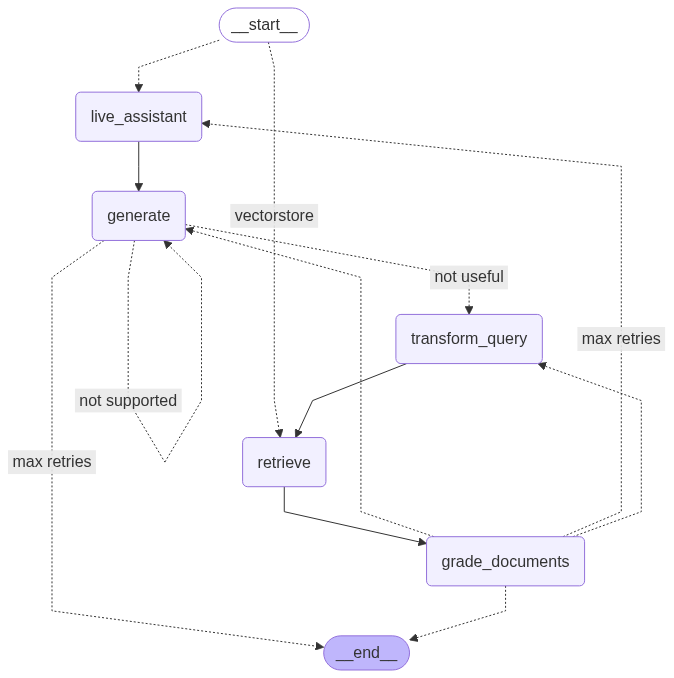

In [47]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Use Graph

## test 1

In [48]:
from pprint import pprint

# Run
inputs = {
    "question": "What player at the Bears expected to draft first in the 2024 NFL draft?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'live_assistant':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Чикаго Бирс ожидается выбрать Калеба Уильямса с первым пиком на драфте НФЛ '
 '2024 года.')


## test 2

Trace:

https://smith.langchain.com/public/7e3aa7e5-c51f-45c2-bc66-b34f17ff2263/r

In [49]:
# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'live_assistant':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Типы памяти агента - это краткосрочная и долгосрочная память. Краткосрочная '
 'память поддерживает мгновенный контекст в пределах одного взаимодействия. '
 'Долгосрочная память сохраняет знания через сессии, задачи и время.')


Trace:

https://smith.langchain.com/public/fdf0a180-6d15-4d09-bb92-f84f2105ca51/r

## test 3

In [50]:
# q= "What player at the Bears expected to draft first in the 2024 NFL draft?"
# q = "Назовите столицу Франции."
#q = "Какие населённые пункты Чеченской республики были подвергнуты ракетно-бомбовым ударам в ночь и утро, согласно сведениям МВД Чечни?"
q= "Югославия"
#rez1 = app.invoke({"question": q})
rez3 = app.invoke({"question": q})

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION DOES NOT ADDRESS QUESTION---
---TRANSFORM QUERY---
!!!transform_query loop_step: 1, loop_step_query: 0!!! 
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
!!!transform_query loop_step: 1, loop_step_query: 1!!! 
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: 

In [51]:
rez3.keys()

dict_keys(['question', 'generation', 'documents', 'loop_step', 'loop_step_query'])

In [52]:
rez3['documents']

Document(metadata={}, page_content="Yugoslavia (/ˌjuːɡoʊˈslɑːviə/; lit.\u2009'Land of the South Slavs') was a country in the Balkans that existed from 1918 to 1992. It came into existence following World War I, under the name of the Kingdom of Serbs, Croats and Slovenes from the merger of the Kingdom of Serbia with the provisional State of Slovenes, Croats and Serbs, and constituted the first union of South Slavic peoples as a sovereign state, following centuries of foreign rule over the region under the Ottoman Empire and the [...] | History |  |\n|  | |\n| • Creation | 1 December 1918 |\n| • Axis invasion | 6 April 1941 |\n| • Abolition of monarchy | 29 November 1945 |\n| • Disintegration | 27 April 1992 |\n|  | |\n| Population | |\n|  | |\n| • 1955 | 17,522,438 |\n| • 1965 | 19,489,605 |\n| • 1975 | 21,441,297 |\n| • 1985 | 23,121,383 |\n| • 1991 | 23,532,279 |\n|  | |\n| Currency | Yugoslav dinar |\n| Calling code | 38 |\n| ISO 3166 code | YU |\n| Internet TLD | .yu |\nelaborate hi

In [53]:
rez3['loop_step_query'], rez3['loop_step']

(3, 3)

In [54]:
rez3['generation']

'Создание Королевства Сербов, Хорватов и Словенцев в 1918 году объединило южнославянские народы в суверенное государство после столетий иностранного владычества. Религиозные конверсии, культурные гибридизации и миграционные движения сформировали сложный этнический мозаичный образ. Различные историко-политические традиции и религиозные взгляды создали пропасти, которые мешали формированию общего югославского идентитета.'

In [55]:
rez3.keys()

dict_keys(['question', 'generation', 'documents', 'loop_step', 'loop_step_query'])

In [56]:
print(rez3['question'])
print(rez3['generation'])
#print(rez1['documents'])

What key historical events and cultural traits have shaped the history of Yugoslavia?
Создание Королевства Сербов, Хорватов и Словенцев в 1918 году объединило южнославянские народы в суверенное государство после столетий иностранного владычества. Религиозные конверсии, культурные гибридизации и миграционные движения сформировали сложный этнический мозаичный образ. Различные историко-политические традиции и религиозные взгляды создали пропасти, которые мешали формированию общего югославского идентитета.


In [57]:
rez3['documents'].page_content

"Yugoslavia (/ˌjuːɡoʊˈslɑːviə/; lit.\u2009'Land of the South Slavs') was a country in the Balkans that existed from 1918 to 1992. It came into existence following World War I, under the name of the Kingdom of Serbs, Croats and Slovenes from the merger of the Kingdom of Serbia with the provisional State of Slovenes, Croats and Serbs, and constituted the first union of South Slavic peoples as a sovereign state, following centuries of foreign rule over the region under the Ottoman Empire and the [...] | History |  |\n|  | |\n| • Creation | 1 December 1918 |\n| • Axis invasion | 6 April 1941 |\n| • Abolition of monarchy | 29 November 1945 |\n| • Disintegration | 27 April 1992 |\n|  | |\n| Population | |\n|  | |\n| • 1955 | 17,522,438 |\n| • 1965 | 19,489,605 |\n| • 1975 | 21,441,297 |\n| • 1985 | 23,121,383 |\n| • 1991 | 23,532,279 |\n|  | |\n| Currency | Yugoslav dinar |\n| Calling code | 38 |\n| ISO 3166 code | YU |\n| Internet TLD | .yu |\nelaborate history of migratory movements from v

# UI Gradio

In [58]:
import gradio as gr

## test 1

In [59]:
def chat_function(message: str, history: list[tuple[str, str]]) -> str:
    result = app.invoke({"question": message})
    if type(result['documents']) == Document:
      # DB do not have relevant docs
      answer = f"""Младший менеджер(по материалам Базы знаний) не смог найти ответ.
      Отвечает Старший менеджер(web_search):\n""" + result["generation"]
    elif type(result['documents']) is list and len(result['documents']) > 0:
      doc_ref = "\n\n\nСсылки на источники в БД.\n"
      for doc in result['documents']:
        #doc_ref += "id: " + doc.metadata['id'] + "\n"
        doc_ref += "title: " + doc.metadata['title'] + "\n"
        doc_ref += "url: " + doc.metadata['url'] + "\n"
        doc_ref += "\n"
      answer = "Младший менеджер(по материалам Базы знаний) отвечает: \n" + result["generation"] + doc_ref
    else:
       answer = "Младший менеджер(по материалам Базы знаний) отвечает: \n я не смог найти ответ в базе знаний и старший менеджер не знает"
    return answer

# Интерфейс чата
chat_ui = gr.ChatInterface(
    fn=chat_function,
    title="🧠 Простой чат без истории (LangGraph + Gradio)",
    chatbot=gr.Chatbot(),
    textbox=gr.Textbox(placeholder="Введите вопрос...", lines=1),
    description="Отвечает на вопросы без использования истории сообщений.",
)

# if __name__ == "__main__":
#     chat_ui.launch()
chat_ui.launch(share=True, debug=True)

/tmp/ipython-input-59-2612881764.py:23: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot=gr.Chatbot(),
/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:322: UserWarning: The gr.ChatInterface was not provided with a type, so the type of the gr.Chatbot, 'tuples', will be used.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5327c8da73d809418d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: MAX RETRIES REACHED---
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https

In [60]:
# "Назовите столицу Франции."
Q_relevant = [
"Какие меры были предприняты в Южно-Сахалинске для борьбы со вспышкой холеры среди жителей поселков Христофоровка и Октябрьский?",
"Какую сумму, по данным МВД России и американских спецслужб, получил Шамиль Басаев и сколько из этой суммы он уже истратил во время боевой кампании в Дагестане?",
"Какие спутники были выведены на орбиту с помощью ракеты-носителя 'Протон-К' с космодрома Байконур после двухмесячного перерыва?",
"За что Павел Бородин планирует подать в суд на газету 'Corriere della Sera' и на некоторые российские СМИ?",
"Какое основное нарушение налогового законодательства было выявлено Министерством по налогам и сборам при массовых проверках автозаправочных станций?",
"Сколько, по предварительным данным, составляют запасы газа в открытом месторождении в районе Каспийского моря, относящемся к территории Азербайджана?",
"Кто является возбудителем менингита в Волгограде, и каким образом этот вирус передается человеку?",
"Почему Израиль начал освобождение палестинских заключённых и сколько человек вышло на свободу в первой группе?",
"Какие населённые пункты Чеченской республики были подвергнуты ракетно-бомбовым ударам в ночь и утро, согласно сведениям МВД Чечни?",
"Какую разработанную учеными систему задержали на приморском участке российско-китайской границы и в чем заключалась её двойная направленность?",
"Кто получил главный приз 56-го Венецианского международного кинофестиваля и за какой фильм?"
]

In [61]:
Q_not_relevant = [
    "Кто написал роман «Война и мир»?",
    "Назовите столицу Франции.",
    "Чему равна сумма углов треугольника?",
    "Кто открыл закон всемирного тяготения?",
    "Что такое фотосинтез?",
    "В каком году началась Вторая мировая война?",
    "Какова формула воды?",
    "Перечислите падежи русского языка.",
    "Что показывает географическая широта точки на Земле?",
    "Какой орган отвечает за перекачивание крови в организме человека?"
]

# link to Langsmith
Trace how can work system for question "Югославия"

https://smith.langchain.com/public/7922a7b2-6019-45ec-9bf7-b45f7da166b7/r